## This notebook outlines the process for obtaining a forecasting model for the hydrometry level in River Arno in Italy, using the dataset for the Acea Smart Water Analytics competition. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import statsmodels as sm
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

### Data Preprocessing

#### The columns consist of:

    - daily rainfall values (in cm) in 14 different regions
    - Temperature (in Celcius)
    - Hydrometry (water level in meters)
    
    
#### The goal is to obtain a forecasting model for Hydrometry given past rainfall, hydrometry and temperature values. 
We start with constructing a daily forecasting model with daily hydrometry difference as the target, then construct a daily forecasting model with residual + trend components after a Seasonal-Trend decomposition</span>

#### Since entries before "01/01/2004" and after "01/07/2007" include missing values, we drop them. We also set the Date as the index of the pandas dataframe. 

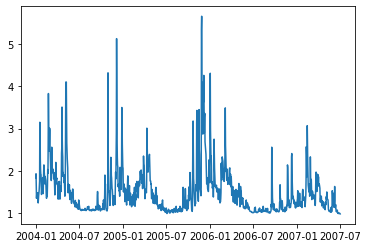

In [3]:
# read data 
df = pd.read_csv("acea-water-prediction/River_Arno.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df.drop(df[df.Date < pd.to_datetime("01/01/2004", dayfirst=True)].index, inplace=True)
df.drop(df[df.Date > pd.to_datetime("01/07/2007", dayfirst=True)].index, inplace=True)
df.fillna(0, inplace=True)
df.head()

df = df.set_index("Date")
df.head()

plt.plot(df["Hydrometry_Nave_di_Rosano"])

#### Split data between "01/01/2004" and "01/07/2007" into training, validation and test splits
#### Entries outside this range have many missing entries and negatively affect the forecasting performance

In [4]:
def split(data, train_frac=0.7, val_frac=0.30):
    
    # contiguous split
    train_delim = int(train_frac * len(data))
    val_delim = int((train_frac + val_frac) * len(data))

    indices = data.index
    start, end = indices[0], indices[train_delim - 1]
    train = data[start:end]
    
    start, end = indices[train_delim], indices[val_delim - 1]
    val = data[start:end]
    
    if val_delim < len(data):
        start = indices[val_delim]
        test = data[start:]
        
    else:
        test = []
    
    return train, val, test

In [5]:
train_df, val_df, test_df = split(df)
print("{} training samples, {} validation samples, {} test samples".format(len(train_df), len(val_df), len(test_df)))


894 training samples, 384 validation samples, 0 test samples


## EDA on rainfall data
### We examine rainfall series to check for large correlations and determine whether dimensionality reduction is required before applying linear regression with rainfall values as covariates. 

In [6]:
# represent rainfall data as column vectors of a matrix X 
columnVals = train_df.columns.map(lambda x: x.startswith("Rainfall"))

df_rainfall = train_df.filter(df.columns[columnVals], axis=1)
X_rain = df_rainfall.to_numpy()
N, d = X_rain.shape
print(N, d)

894 14


#### The correlation matrix of rainfall values in different regions suggests that we may leverage a lower dimensional representation of rainfall values on a given day. 

#### Rainfall in regions 0 to 5 are highly correlated with each other but have low correlation with rainfall values in regions 6 to 13. 
#### Similarly, rainfall in regions 6 to 13 are highly correlated with each other. 

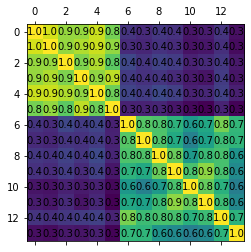

In [7]:
# compute mean rainfall vector 
mean_rainfall = X_rain.mean(axis=0, keepdims=True)

# Compute normalized feature vectors for rainfall data
X_rain_norml = X_rain - mean_rainfall
std_rainfall = np.sqrt(np.power(X_rain_norml, 2).mean(axis=0))[:, np.newaxis]
X_rain_norml = X_rain_norml / std_rainfall.T

corr_rain = X_rain_norml.T.dot(X_rain_norml) / N
fig, ax = plt.subplots()
ax.matshow(corr_rain)

for (i, j), z in np.ndenumerate(corr_rain):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


### We perform PCA on rainfall data and plot the reconstruction error vs. the number of principal components chosen. 

Fraction of Error:  0.16102748399644493
Reconstruction Error:  2.4100589607366247


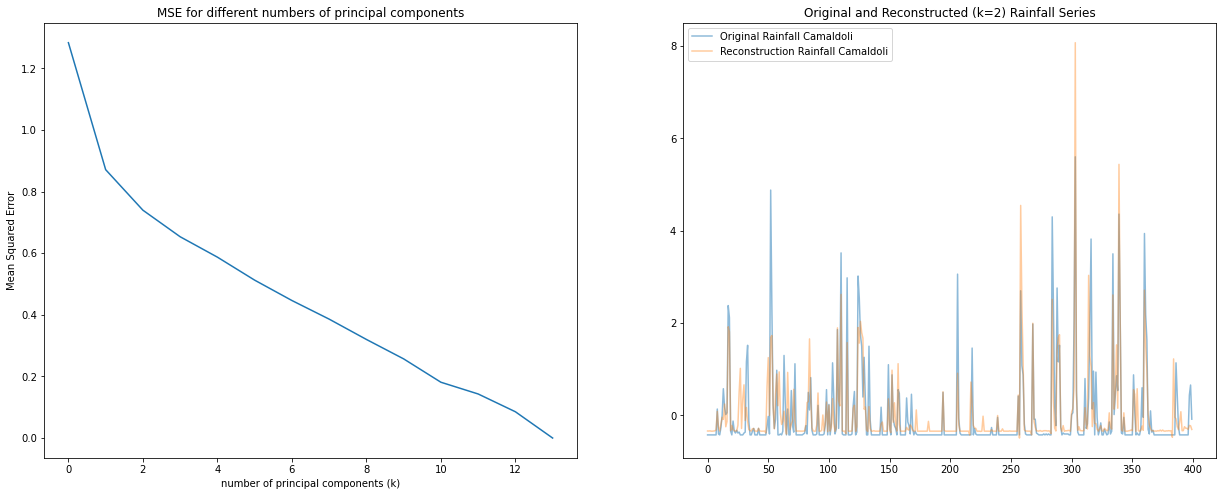

In [8]:
# Perform PCA on rainfall data 
u, s, vh = np.linalg.svd(corr_rain, full_matrices=True)

# Use the elbow method to choose the number of principal components 
errors = []
sigma = np.diag(s)

for k in range(1, X_rain_norml.shape[-1] + 1):
    proj = vh[:k, :].dot(X_rain_norml.T) 
    recon = u[:, :k].dot(proj) 
    diff = X_rain_norml - recon.T
    mse = np.linalg.norm(diff, ord=2, axis=-1).mean()
    errors.append(mse)
    

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(21, 8)


ax[0].plot(errors)
ax[0].set_title("MSE for different numbers of principal components")
ax[0].set_xlabel("number of principal components (k)")
ax[0].set_ylabel("Mean Squared Error")

proj = vh[:2, :].dot(X_rain_norml.T) # k x N
recon = u[:, :2].dot(proj)

og = ax[1].plot(X_rain_norml[:400, -1], alpha=0.5, label="Original Rainfall Camaldoli")
re = ax[1].plot(recon.T[:400, -1], alpha=0.4, label="Reconstruction Rainfall Camaldoli")
ax[1].set_title("Original and Reconstructed (k=2) Rainfall Series")
ax[1].legend(loc="upper left")
recon_error = np.power(recon.T - X_rain_norml, 2).sum(axis=-1)

print("Fraction of Error: ", (recon_error / np.power(X_rain_norml, 2).sum(axis=-1)).mean())
print("Reconstruction Error: ", recon_error.mean())


#### PCA does not look like a reasonable choice for reducing the dimensionality of rainfall values. 
#### This fact is hinted at by the slow reduction in reconstruction error as the number of principal directions is increased. 
#### We also show below that days with heavy rainfall in one or more regions are not well captured by the two principal components. 
#### These values are expected to increase hydrometry levels and should therefore be adequately represented. 

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'MSE after PCA with k=2 vs. norm of rainfall features')

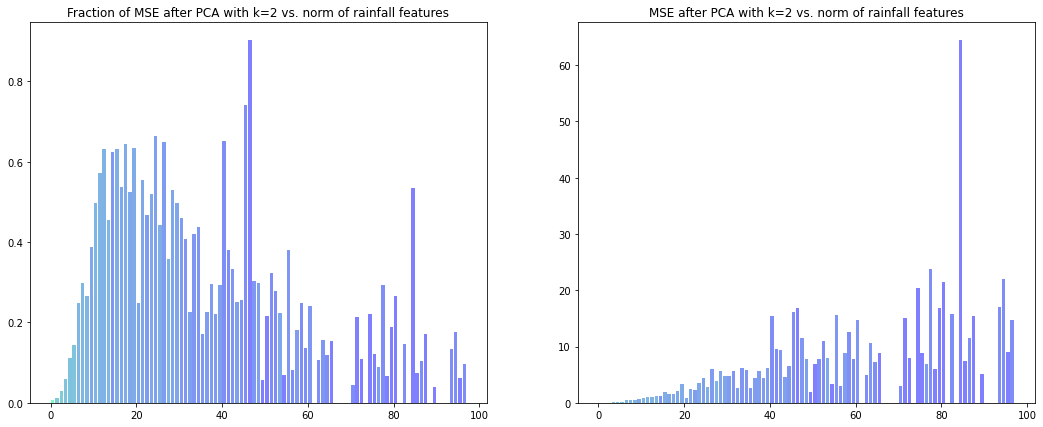

In [9]:
delim = [i for i in range(100)]

dist = np.linalg.norm(X_rain, ord=2, axis=-1)
recon_errors = np.power(recon.T - X_rain_norml, 2).sum(1)
frac_errors = recon_errors / np.power(X_rain_norml, 2).sum(axis=-1)

hydrometry = train_df["Hydrometry_Nave_di_Rosano"]
hist_errors = []
hist_frac_errors = []
hist_counts = []

for i, d in enumerate(delim[:-1]):
    indices = np.argwhere(np.logical_and(dist >= delim[i], dist < delim[i+1]))
    hist_frac_errors.append(frac_errors[indices].mean())
    hist_errors.append(recon_errors[indices].mean())
    hist_counts.append(len(indices))

x = [0.5 * (delim[i] + delim[i+1]) for i in range(99)]    

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
hist_counts = np.log(np.array(hist_counts))
color = matplotlib.cm.get_cmap("winter")(hist_counts / max(hist_counts))
ax[0].bar(x=x, height=hist_frac_errors, alpha=0.5, color=color)
ax[0].set_title("Fraction of MSE after PCA with k=2 vs. norm of rainfall features")

ax[1].bar(x=x, height=hist_errors, alpha=0.5, color=color)
ax[1].set_title("MSE after PCA with k=2 vs. norm of rainfall features")



#### The bar graph above shows the mean reconstruction error (y-axis) for different magnitudes of rainfall feature vectors (x-axis). 
#### We see that at large distances, the mean reconstruction error is much larger. These points do not contribute much to the overall mean reconstruction error, but they have a large influence on hydrometry. 

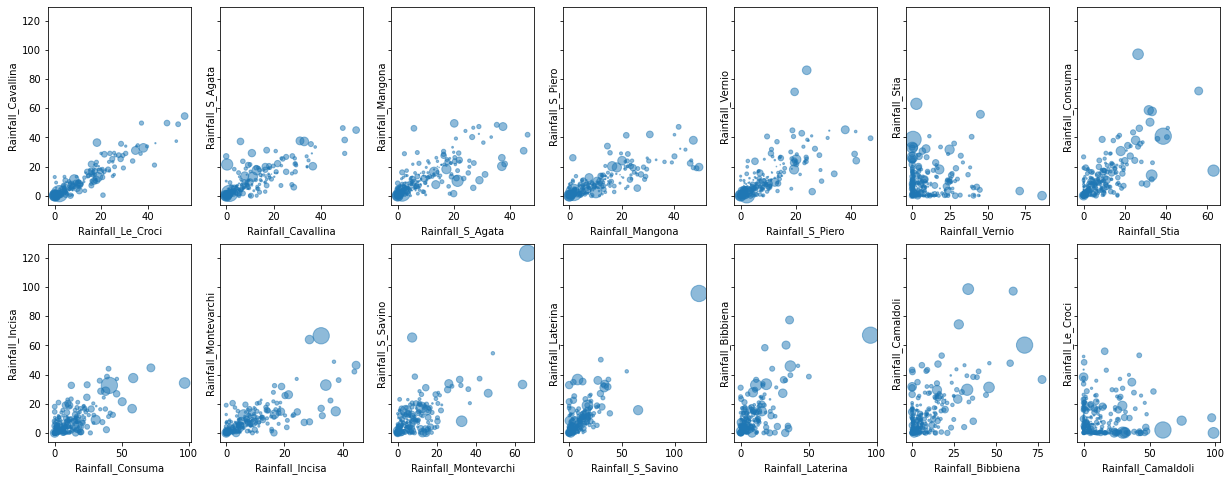

In [10]:
N, d = X_rain_norml.shape
fig, ax = plt.subplots(2, 7, sharex=False, sharey=True)
fig.set_size_inches(21, 8)
recon_errors = np.power(recon.T - X_rain_norml, 2).sum(1) 
for i, col in enumerate(df_rainfall.columns):
    j = i + 1 if i < d - 1 else 0
    ax[i // 7, i % 7].scatter(df_rainfall[col], df_rainfall[df_rainfall.columns[j]], alpha=0.5, s=2 * recon_errors) 
    ax[i // 7, i % 7].set_xlabel(col)
    ax[i // 7, i % 7].set_ylabel(df_rainfall.columns[j])

#### The figure above shows scatter plots of rainfall values in different regions. For most pairs of regions, we notice a strong correlation and a linear relationship for small rainfall values. Larger rainfall values, at one or more regions deviate further from the linear relationship and have a larger reconstruction error from the top 2 principal components, as demonstrated by the larger marker sizes. 

### Inspection of Time Dependence

### Since hydrometry is seasonal, and values are time-dependent, we use the difference between hydrometry values at consecutive days as the target. 

Text(0.5, 1.0, 'Hydrometry Difference')

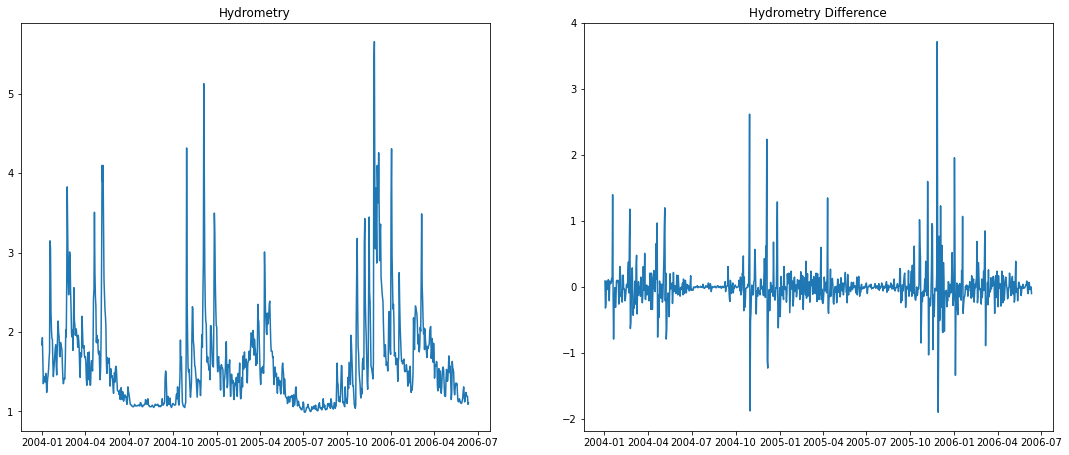

In [11]:
hydrometry = train_df["Hydrometry_Nave_di_Rosano"]
hydrometry.head()

fig, ax = plt.subplots(1, 2, squeeze=False)

fig.set_size_inches(18.5, 7.5)

ax[0, 0].plot(hydrometry)
ax[0, 0].set_title("Hydrometry")

ax[0, 0].set_aspect("auto")
ax[0, 1].set_aspect("auto")

hydro_diff = (hydrometry - hydrometry.shift(1))[1:-1]
ax[0, 1].plot(hydro_diff)
ax[0, 1].set_title("Hydrometry Difference")

### We plot the Autocorrelation function of "Hydrometry" and notice that the ACF does not decay very quickly, and exhibits oscillations. Differencing allows us to remove long-term dependencies from the series. 

Text(0.5, 1.0, 'PACF Hydrometry')

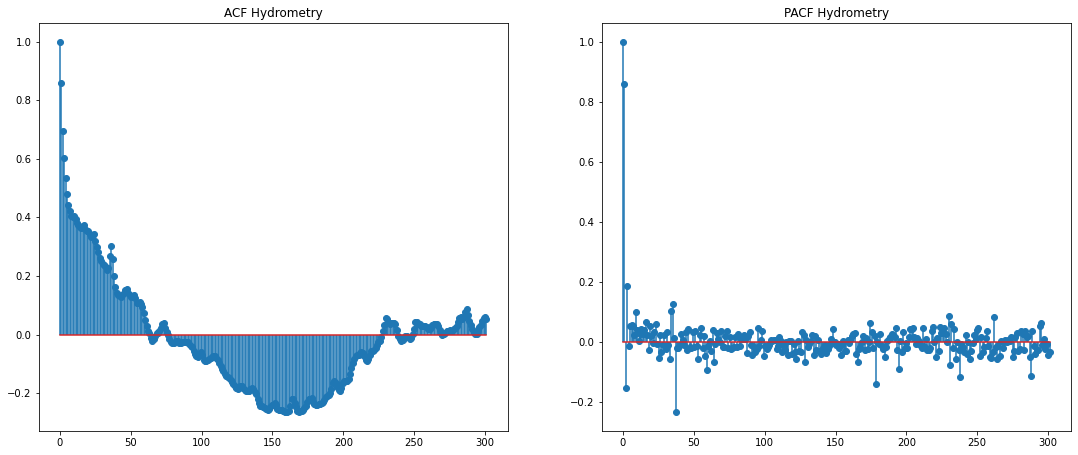

In [186]:
x = np.linspace(0, 301, 301)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

acov = sm.tsa.stattools.acf(hydrometry, fft=False, nlags=300)
ax[0, 0].stem(x, acov, use_line_collection=True)
ax[0, 0].set_title("ACF Hydrometry")

pacov = sm.tsa.stattools.pacf(hydrometry, nlags=300)
ax[0, 1].stem(x, pacov, use_line_collection=True)
ax[0, 1].set_title("PACF Hydrometry")

### We plot the autocovariance function of "Hydrometry Difference" to obtain a heuristic for the order p of the AR(p) model. 

### Note that the PACF computes the correlation between values at different time lags while accounting for the correlation between values at smaller time lags, and is a better indicator of the required order p. 

Text(0.5, 1.0, 'PACF Hydrometry Difference')

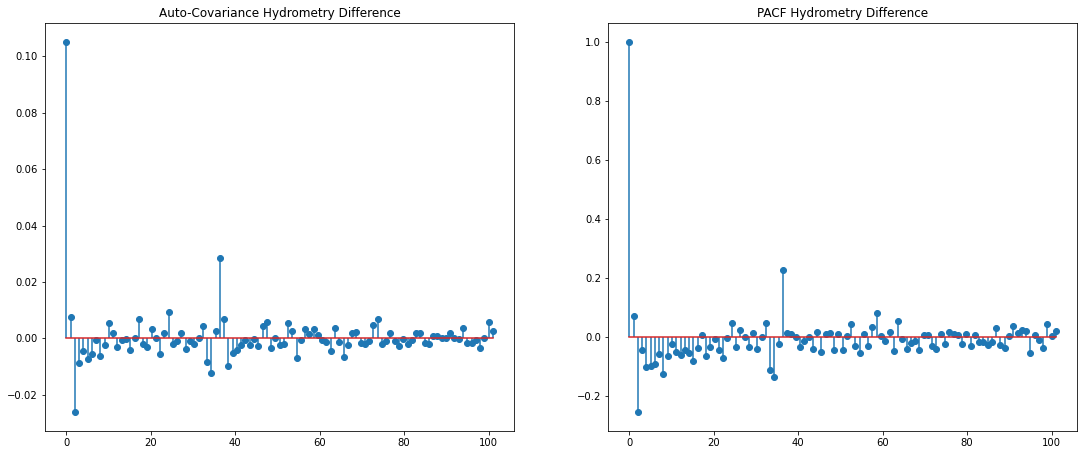

In [187]:
x = np.linspace(0, 101, 101)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

acov = sm.tsa.stattools.acovf(hydro_diff, fft=False, nlag=100)
ax[0, 0].stem(x, acov, use_line_collection=True)
ax[0, 0].set_title("Auto-Covariance Hydrometry Difference")

pacov = sm.tsa.stattools.pacf(hydro_diff, nlags=100)
ax[0, 1].stem(x, pacov, use_line_collection=True)
ax[0, 1].set_title("PACF Hydrometry Difference")

### The following plots show the cross-covariance at different time-lags between hydrometry difference and the top-2 principal components of rainfall values. Unlike the cross-covariance plots using the standardized rainfall values (shown next), we cannot deduce a clear order for the regression model. 

Text(0.5, 1.0, 'Cross-Covariance with second principal component')

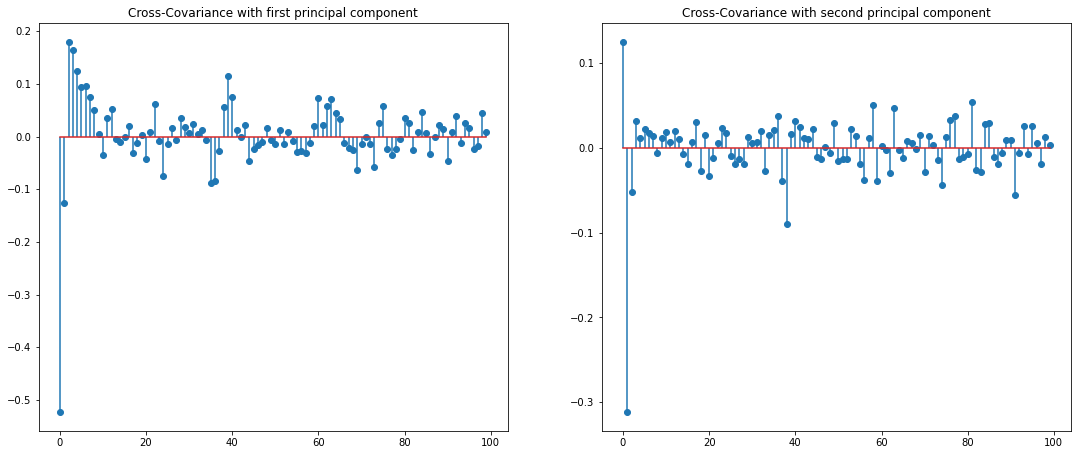

In [14]:
# compute cross-covariance between hydrometry difference and rainfall representations
# rainfall was projected onto 2 principal components 
x = np.linspace(0, 99, 100)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

ccov_1 = sm.tsa.stattools.ccovf(hydro_diff, proj.T[1:-1, 0])
ccov_2 = sm.tsa.stattools.ccovf(hydro_diff, proj.T[1:-1, 1])

ax[0, 0].stem(x, ccov_1[0:100], use_line_collection=True)
ax[0, 0].set_title("Cross-Covariance with first principal component")
ax[0, 1].stem(x, ccov_2[0:100], use_line_collection=True)
ax[0, 1].set_title("Cross-Covariance with second principal component")

### We plot the cross-covariance between "Hydrometry Difference" and standardized rainfall values at different time-lags. Notice that "Hydrometry Difference" has a large positive covariance with rainfall in regions 0 to 5 at lag 1, which is not present for rainfall in regions 6 to 13. The negative cross-covariance values at larger time-lags may be due to decreasing hydrometry levels after an initial rise due to rainfall as water in the river flows to the sea. 

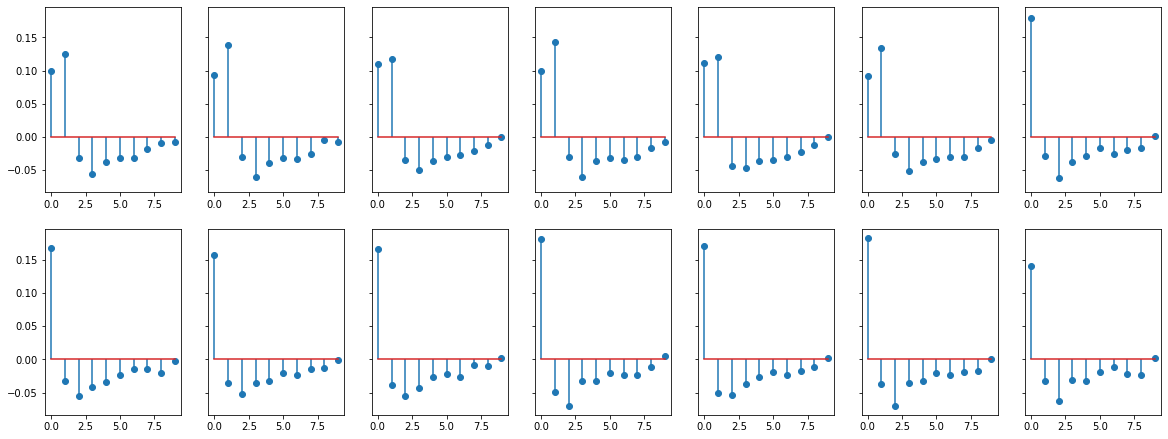

In [15]:
x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(2, 7, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

for i in range(X_rain_norml.shape[-1]):
    ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_norml[1:-1, i])
    ax[i // 7, i % 7].stem(x, ccov[:10], use_line_collection=True)

### Feature Engineering for Rainfall Series

### While the cross-covariance between "Hydrometry Difference" and standardized rainfall values are more easily interpretable, the rainfall entries are still highly correlated which can increase the variance of the estimated model's parameters. We construct a lower dimensional rainfall feature vector below. 

### Our resulting rainfall features are 2-dimensional where the first component is the l1 norm of rainfall in regions 0 to 5, and the second component is the l1 norm of rainfall in regions 6 to 13. Grouping the rainfall features this way is consistent with the cross-covariance shown above.

Text(0.5, 1.0, 'Cross-Correlation with second rainfall feature')

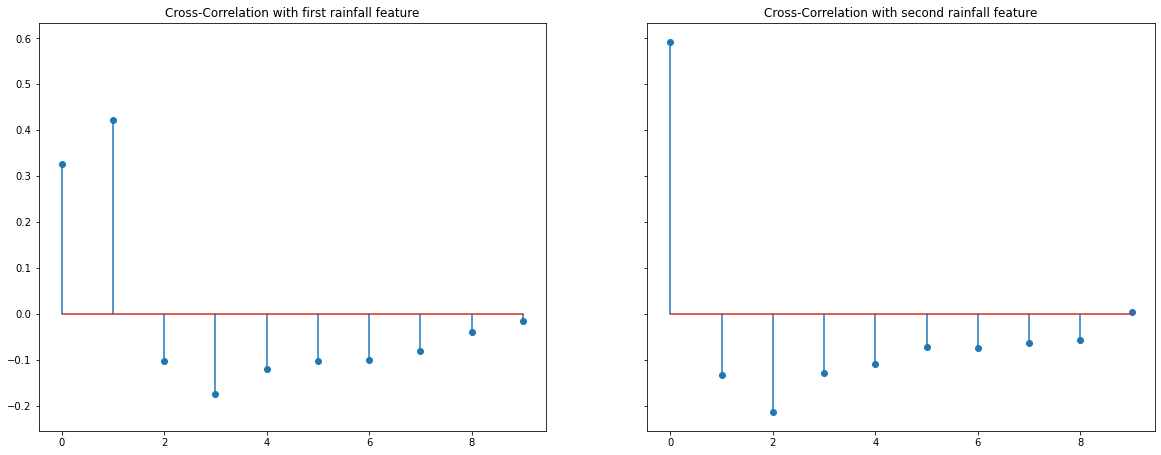

In [75]:
# split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
# and the second component is a function of rainfall in region 2: columns 6 to 13 
X_rain_1 = np.power(X_rain[:, 0:6], 1).sum(-1)
X_rain_2 = np.power(X_rain[:, 6:], 1).sum(-1)

std_rain_1 = np.std(X_rain_1)
std_rain_2 = np.std(X_rain_2)
std_hydro = np.std(hydro_diff)

x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(1, 2, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_1[1:-1])
ax[0].stem(x, ccov[:10] / (std_rain_1 * std_hydro), use_line_collection=True)
ax[0].set_title("Cross-Correlation with first rainfall feature")

ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_2[1:-1])
ax[1].stem(x, ccov[:10] / (std_rain_2 * std_hydro), use_line_collection=True)
ax[1].set_title("Cross-Correlation with second rainfall feature")

### While the cross-covariances appear to taper off at lag 9, rainfall features might exhibit strong correlations at different time-lags. This leads to the estimated coefficients having a large variance. We therefore check for strong correlations among rainfall features at different time lags. 

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/stattools.py:693: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Cross-Correlation between Rainfall features 1 & 2')

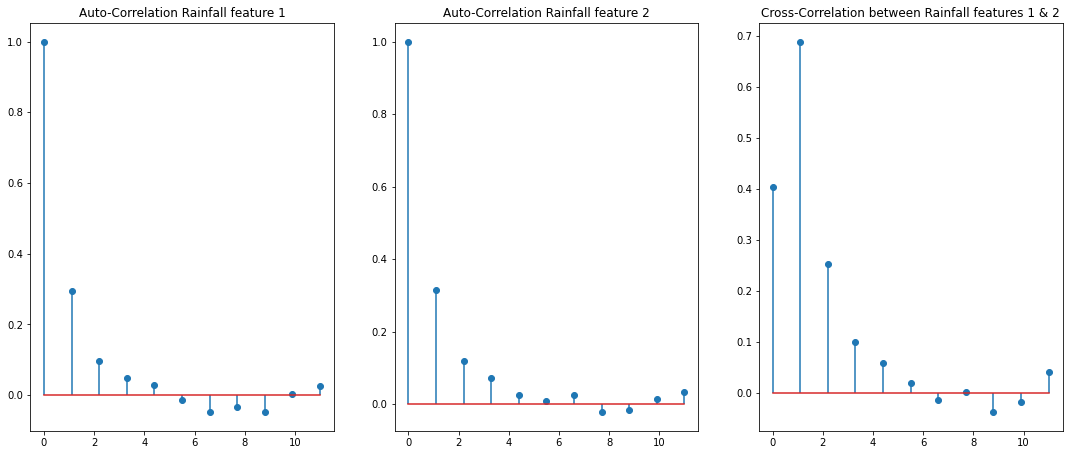

In [188]:
x = np.linspace(0, 11, 11)
fig, ax = plt.subplots(1, 3, squeeze=False)
fig.set_size_inches(18.5, 7.5)

std_1 = np.std(X_rain_1)
std_2 = np.std(X_rain_2)

acov = sm.tsa.stattools.acf(X_rain_1, fft=False, nlags=10)
ax[0, 0].stem(x, acov, use_line_collection=True)
ax[0, 0].set_title("Auto-Correlation Rainfall feature 1")

pacov = sm.tsa.stattools.acf(X_rain_2, nlags=10)
ax[0, 1].stem(x, pacov, use_line_collection=True)
ax[0, 1].set_title("Auto-Correlation Rainfall feature 2")

ccov = sm.tsa.stattools.ccovf(X_rain_2, X_rain_1)
ax[0, 2].stem(x, ccov[0:11] / (std_1 * std_2), use_line_collection=True)
ax[0, 2].set_title("Cross-Correlation between Rainfall features 1 & 2")


### While rainfall features 1 and 2 are not correlated at the current time-step (which is also reflected by the correlation matrix) they are highly correlated at lag 1. We will show below that using the rainfall features for the past 8 days leads to the estimated regression coefficients having a large variance. 

#### We examine the cross-covariance between temperature and hydrometry difference. 

Text(0.5, 1.0, 'Temperature Difference')

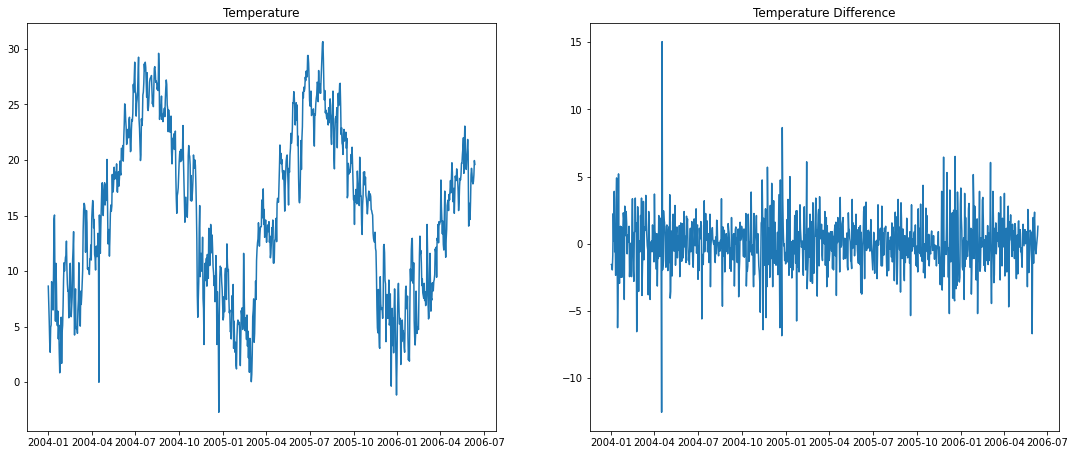

In [189]:
# temperature
temp = train_df["Temperature_Firenze"]
temp_diff = (temp - temp.shift(1))[1:-1]

fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

ax[0, 0].plot(temp)
ax[0, 0].set_title("Temperature")
ax[0, 1].plot(temp_diff)
ax[0, 1].set_title("Temperature Difference")

### The cross-correlation between "Hydrometry Difference" and "Temperature" as well as "Temperature Difference" are too small. We therefore omit the temperature feature from the ARIMA model. 

<StemContainer object of 3 artists>

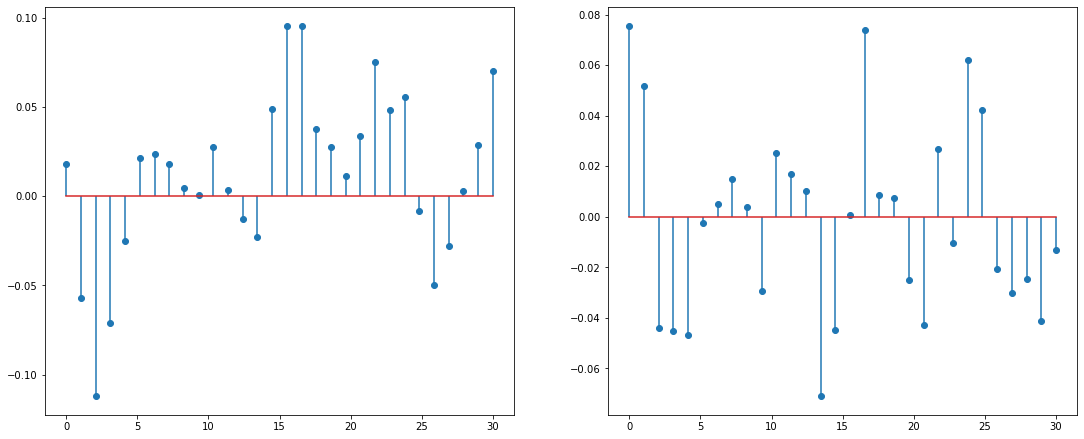

In [193]:
# compute cross-covariance between hydrometry difference and temperature
x = np.linspace(0, 30, 30)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

hydro_diff_std = np.std(hydro_diff)
temp_std = np.std(temp_diff)
temp_diff_std = np.std(temp_diff)

ccov = sm.tsa.stattools.ccovf(hydro_diff, temp[1:-1])
ax[0, 0].stem(x, ccov[0:30] / (hydro_diff_std * temp_std), use_line_collection=True)

ccov = sm.tsa.stattools.ccovf(hydro_diff, temp_diff)
ax[0, 1].stem(x, ccov[0:30] / (hydro_diff_std * temp_diff_std), use_line_collection=True)

In [221]:
def get_train_features(dataframe, max_lag):
    
    columnVals = dataframe.columns.map(lambda x: x.startswith("Rainfall"))
    df_rainfall = dataframe.filter(df.columns[columnVals], axis=1)
    X_rain = df_rainfall.to_numpy()
    
    # split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
    # and the second component is a function of rainfall in region 2: columns 6 to 13 
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=1, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=1, axis=-1) / 100

    # shift by max_lag + 1 because we are matching rainfall with hydrometry difference
    data = {"rainfall_1": rainfall_1[max_lag+1:],
            "rainfall_2": rainfall_2[max_lag+1:]}
        
    for i in range(1, max_lag + 1):
        # use max_lag-i + 1 as starting index for series delayed by i steps
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i+1:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i+1:-i]
        
    hydrometry = dataframe["Hydrometry_Nave_di_Rosano"]
    target = pd.DataFrame({"hydrometry_diff": (hydrometry - hydrometry.shift(1))[max_lag+1:]}, 
                          index=train_df.index[max_lag+1:])
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target


def get_val_features(train_df, val_df, max_lag):
    
    columnVals = train_df.columns.map(lambda x: x.startswith("Rainfall"))
    
    df_rainfall = train_df[-max_lag:].filter(df.columns[columnVals], axis=1)
    df_rainfall = pd.concat([df_rainfall, val_df.filter(df.columns[columnVals], axis=1)])
    
    X_rain = df_rainfall.to_numpy()
    
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=1, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=1, axis=-1) / 100

    # since prev value is found in training set, we don't need to shift by 1
    data = {"rainfall_1": rainfall_1[max_lag:],
            "rainfall_2": rainfall_2[max_lag:]}
        
    for i in range(1, max_lag + 1):
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i:-i]
        
    hydrometry = pd.concat([train_df["Hydrometry_Nave_di_Rosano"][-1:], val_df["Hydrometry_Nave_di_Rosano"]])
    target = pd.DataFrame({"hydrometry_diff": (hydrometry - hydrometry.shift(1))[1:]}, 
                          index=val_df.index)
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target


def get_metrics(pred, gt):
    
    mse = np.power(pred - gt, 2).mean()
    mae = np.abs(pred - gt).mean()
    avg = np.mean(gt)
    r2 = 1 - np.power(pred - gt, 2).sum() / np.power(gt - avg, 2).sum()
    return mse, mae, r2


def get_forecast(exog, target, results, horizon, get_level=False): 
    
    pred = []
    gt = []
    level_pred = []
    curr_level_gt = 0 
    T = len(target.index)
    
    # call forecasting method every "horizon" number of steps
    for d in range(0, T, horizon):
        
        test_data = exog.iloc[d:d+horizon] if exog is not None else None
        forecast = results.get_forecast(steps=horizon, exog=test_data) 
    
        # update internal state with ground-truth target 
        results = results.append(target.iloc[d:d+horizon], exog=test_data)
        prediction = forecast.predicted_mean.to_numpy()
        pred.append(prediction)
        
        if get_level:
            # compute cumulative sum of changes over forecasting horizon and add initial level 
            level_pred.append(np.cumsum(prediction) + curr_level_gt)
            curr_level_gt += target.iloc[d:d+horizon].to_numpy().sum()
            
            
    pred = np.array(pred).reshape(-1,)
    gt = target.to_numpy().reshape(-1,)
    
    fig, ax = plt.subplots()
    ax.plot(pred, alpha=0.5, label="forecast")
    ax.plot(gt, alpha=0.5, label="target")
    ax.legend(loc="upper left")
    
    mse, mae, r2 = get_metrics(pred, gt)
    
    print("MSE: {0:.3g}".format(mse))
    print("MAE: {0:.3g}".format(mae))
    print("R2: {0:.3g}".format(r2))
    
    if get_level:
        level_pred = np.array(level_pred).reshape(-1,)
        level_gt = np.cumsum(gt)
    
        mse, mae, r2 = get_metrics(level_pred, level_gt)
        print("Level MSE: {0:.3g}".format(mse))
        print("Level MAE: {0:.3g}".format(mae))
        print("Level R2: {0:.3g}".format(r2))
        
        fig, ax = plt.subplots()
        ax.plot(level_pred, alpha=0.5, label="Level forecast")
        ax.plot(level_gt, alpha=0.5, label="Level target")
        ax.legend(loc="upper left")

    return pred, gt

### Since the cross-covariances between "Hydrometry Difference" and rainfall features are much larger than the auto-covariances of "Hydrometry Difference" we start with an p=0 and q=0. That is, the change in hydrometry on day "n" only depends on rainfall in the past 8 days. 

### We notice a standard error that is large for coefficients at larger time lags. Some of the eigenvalues of the correlation matrix of exogenous variables are very close to 0, indicating the presence of colinearity among the exogneous variables. 

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        hydrometry_diff   No. Observations:                  885
Model:                          ARIMA   Log Likelihood                  87.979
Date:                Tue, 16 Mar 2021   AIC                           -135.959
Time:                        10:40:36   BIC                            -40.247
Sample:                    01-10-2004   HQIC                           -99.367
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0137      0.015     -0.900      0.368      -0.043       0.016
rainfall_1           0.0873      0.014      6.027      0.000       0.059       0.116
rainfall_2           0.3587      0.011     34.136      0.000       0.338       0.379
rainfall_2_lag_1    -0.2058      0.010    -19.637      0.000      -0.226      -0.185
rainfall_1_lag_1     0.1224      0.017      7.405      0.000       0.090       0.155
rainfall_2_lag_2    -0.1032      0.019     -5.453      0.000      -0.140      -0.066
rainfall_1_lag_2     0.0069      0.018      0.374      0.708      -0.029       0.043
rainfall_2_lag_3    -0.0302      0.024     -1.271      0.204      -0.077       0.016
rainfall_1_lag_3    -0.0193      0.029     -0.656      0.512      -0.077       0.038
rainfall_2_lag_4    -0.0205      0.021     -0.964      0.335      -0.062       0.021
rainfall_1_lag_4    -0.0197      0.031     -0.634      0.526      -0.081       0.041
rainfall_2_lag_5     0.0145      0.022      0.646      0.518      -0.029       0.058
rainfall_1_lag_5    -0.0221      0.029     -0.750      0.453      -0.080       0.036
rainfall_2_lag_6    -0.0126      0.026     -0.479      0.632      -0.064       0.039
rainfall_1_lag_6    -0.0305      0.033     -0.926      0.354      -0.095       0.034
rainfall_2_lag_7    -0.0068      0.028     -0.246      0.805      -0.061       0.047
rainfall_1_lag_7    -0.0335      0.030     -1.099      0.272      -0.093       0.026
rainfall_2_lag_8    -0.0297      0.016     -1.862      0.063      -0.061       0.002
rainfall_1_lag_8     0.0336      0.036      0.927      0.354      -0.037       0.105
sigma2               0.0480      0.001     38.082      0.000       0.046       0.050
===================================================================================
Ljung-Box (L1) (Q):                   5.19   Jarque-Bera (JB):              4209.42
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

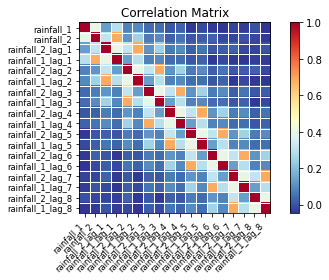

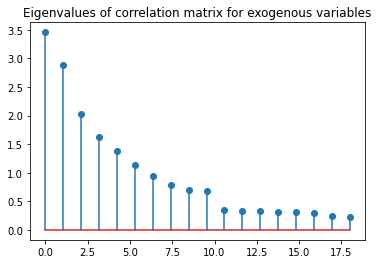

In [212]:
import statsmodels.graphics.api as smg

exog, target = get_train_features(train_df, max_lag=8)

corr_matrix = np.corrcoef(exog.T)

smg.plot_corr(corr_matrix, xnames=exog.columns)
u, s, vh = np.linalg.svd(corr_matrix, full_matrices=True)

fig, ax = plt.subplots()
ax.stem(np.linspace(0, exog.shape[1], exog.shape[1]), s)
ax.set_title("Eigenvalues of correlation matrix for exogenous variables")

model = ARIMA(endog=target, exog=exog, order=(0, 0, 0)) #(p, d, q)
results = model.fit()
results.summary()

In [216]:
exog, target = get_train_features(train_df, max_lag=1)
model = ARIMA(endog=target, exog=exog, order=(0, 0, 0)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        hydrometry_diff   No. Observations:                  892
Model:                          ARIMA   Log Likelihood                  36.429
Date:                Tue, 16 Mar 2021   AIC                            -60.859
Time:                        10:42:31   BIC                            -32.098
Sample:                    01-03-2004   HQIC                           -49.867
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0618      0.013     -4.895      0.000      -0.087      -0.037
rainfall_1           0.0838      0.015      5.744      0.000       0.055       0.112
rainfall_2           0.3522      0.010     33.929      0.000       0.332       0.373
rainfall_2_lag_1    -0.2445      0.007    -33.335      0.000      -0.259      -0.230
rainfall_1_lag_1     0.1285      0.016      8.044      0.000       0.097       0.160
sigma2               0.0540      0.001     39.706      0.000       0.051       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3701.38
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 0.0266
MAE: 0.108
R2: 0.151
Level MSE: 0.0266
Level MAE: 0.108
Level R2: 0.71


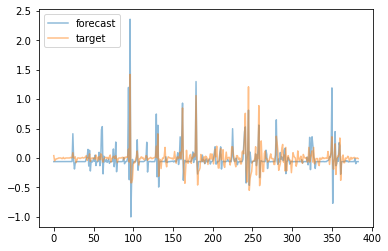

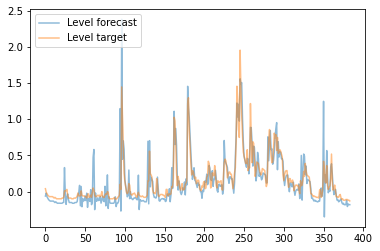

In [219]:
exog, target = get_val_features(train_df, val_df, max_lag=1)
pred, gt = get_forecast(exog, target, results._results, horizon=1, get_level=True)

### As we increase the forecasting horizon, small errors in difference predictions lead to large errors in level predictions

MSE: 0.0266
MAE: 0.108
R2: 0.151
Level MSE: 0.0691
Level MAE: 0.194
Level R2: 0.246


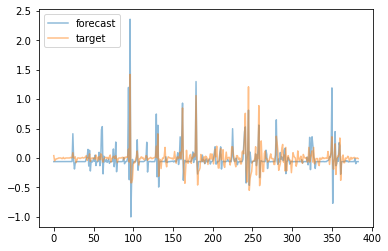

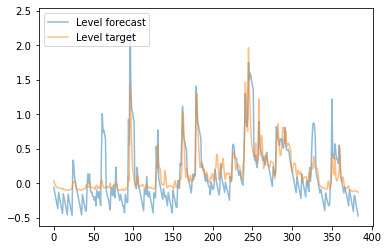

In [222]:
exog, target = get_val_features(train_df, val_df, max_lag=1)
pred, gt = get_forecast(exog, target, results._results, horizon=6, get_level=True)

### The previous model was only dependent on rainfall features and had p=0 and q=0. We examine the performance of a model with AR(1) and MA(1)

In [224]:
exog, target = get_train_features(train_df, max_lag=1)
model = ARIMA(endog=target, exog=exog, order=(1, 0, 1)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        hydrometry_diff   No. Observations:                  892
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  50.991
Date:                Tue, 16 Mar 2021   AIC                            -85.983
Time:                        10:47:13   BIC                            -47.635
Sample:                    01-03-2004   HQIC                           -71.327
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0475      0.008     -5.769      0.000      -0.064      -0.031
rainfall_1           0.0693      0.014      4.861      0.000       0.041       0.097
rainfall_2           0.3468      0.010     33.873      0.000       0.327       0.367
rainfall_2_lag_1    -0.2811      0.009    -32.679      0.000      -0.298      -0.264
rainfall_1_lag_1     0.1160      0.017      6.921      0.000       0.083       0.149
ar.L1                0.6612      0.063     10.505      0.000       0.538       0.785
ma.L1               -0.8206      0.053    -15.350      0.000      -0.925      -0.716
sigma2               0.0522      0.002     33.565      0.000       0.049       0.055
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):              4099.65
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 0.0258
MAE: 0.109
R2: 0.178
Level MSE: 0.0258
Level MAE: 0.109
Level R2: 0.719


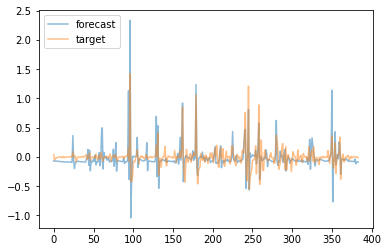

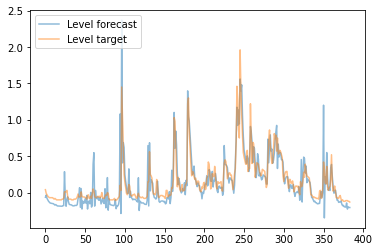

In [225]:
exog, target = get_val_features(train_df, val_df, max_lag=1)
pred, gt = get_forecast(exog, target, results._results, horizon=1, get_level=True)

### The model with AR(1) and MA(1) exhibits better performance over a longer forecasting horizon. This is expected since the AR(1) component allows the model to include longer-term dependencies. 

MSE: 0.0275
MAE: 0.107
R2: 0.122
Level MSE: 0.0536
Level MAE: 0.178
Level R2: 0.416


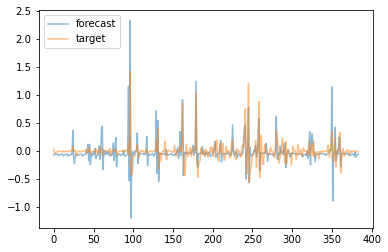

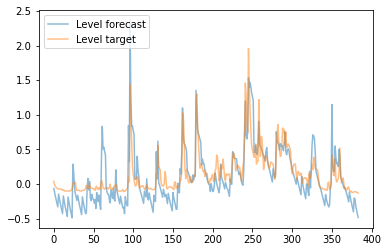

In [226]:
exog, target = get_val_features(train_df, val_df, max_lag=1)
pred, gt = get_forecast(exog, target, results._results, horizon=6, get_level=True)

### We compare the above results with the performance of a baseline model which consists of only an autoregressive component of order 1. 

In [228]:
# baseline: AR(1)
exog, target = get_train_features(train_df, max_lag=2)
model = ARIMA(endog=target, order=(1, 0, 0)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        hydrometry_diff   No. Observations:                  891
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -258.824
Date:                Tue, 16 Mar 2021   AIC                            523.649
Time:                        10:53:28   BIC                            538.026
Sample:                    01-04-2004   HQIC                           529.143
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.015     -0.038      0.970      -0.030       0.029
ar.L1          0.0703      0.016      4.437      0.000       0.039       0.101
sigma2         0.1047      0.001     75.218      0.000       0.102       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             41027.04
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Despite showing lower MAE on the forecast of hydrometry differences, the baseline model exhibits an extremely low R2 score. That is, the sum of residuals squared is greater than the variance of the target values. 

### MAE and MSE are not reliable metrics in the case of this series, since most hydrometry difference values are close to 0 and large changes are rare. While the previous model can forecast large changes which coincide with the target series, the baseline model is consistently close to 0. Its level predictions over a longer forecasting horizon is considerably worse. 

MSE: 0.0316
MAE: 0.0843
R2: -0.00838
Level MSE: 0.0316
Level MAE: 0.0843
Level R2: 0.655


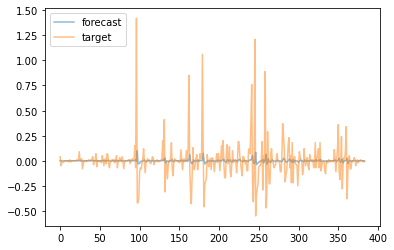

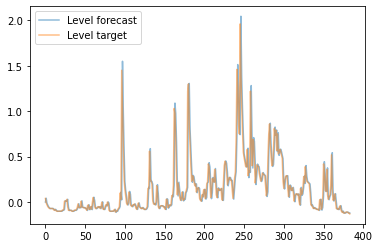

In [229]:
exog, target = get_val_features(train_df, val_df, max_lag=2)
pred, gt = get_forecast(exog=None, target=target, results=results._results, horizon=1, get_level=True)

MSE: 0.0316
MAE: 0.0843
R2: -0.00778
Level MSE: 0.086
Level MAE: 0.142
Level R2: 0.0621


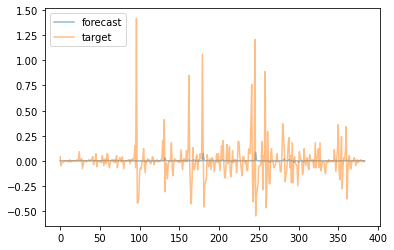

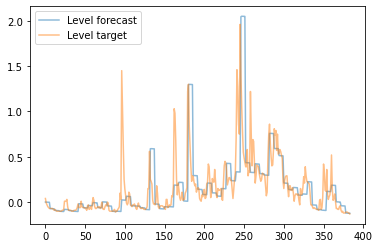

In [230]:
pred, gt = get_forecast(exog=None, target=target, results=results._results, horizon=6, get_level=True)

### Over time, errors in daily prediction of hydrometry difference add up to result in large errors in the overall hydrometry forecast. 
### In the following experiments, we examine the forecasting performance for the residual component of a Seasonal-Trend decomposition of hydrometry. 

Text(0.5, 1.0, 'Hydrometry Residual')

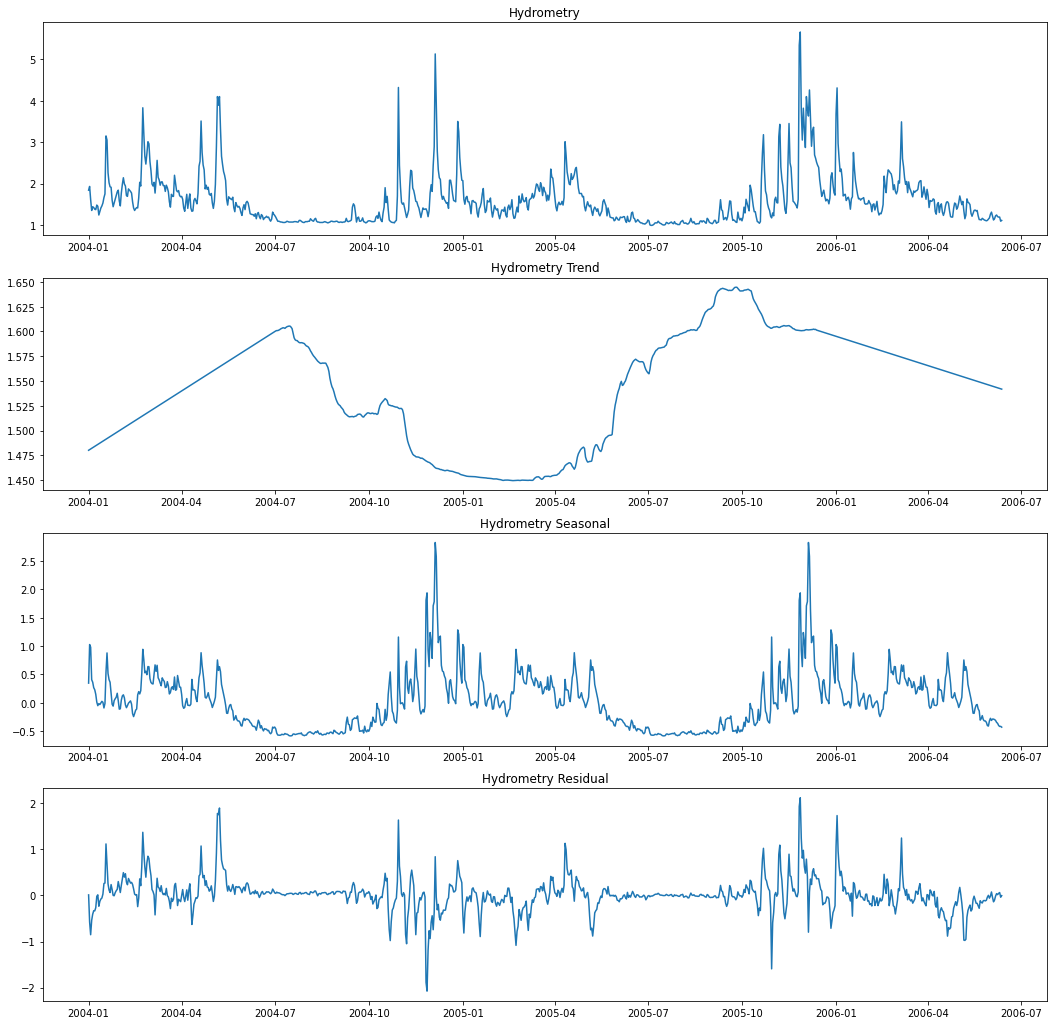

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train_df["Hydrometry_Nave_di_Rosano"], period=365, model='additive', extrapolate_trend=1)

fig, ax = plt.subplots(4, 1)
fig.set_size_inches(18, 18)
ax[0].plot(train_df["Hydrometry_Nave_di_Rosano"])
ax[0].set_title("Hydrometry")

ax[1].plot(decomp.trend)
ax[1].set_title("Hydrometry Trend")

ax[2].plot(decomp.seasonal)
ax[2].set_title("Hydrometry Seasonal")

ax[3].plot(decomp.resid)
ax[3].set_title("Hydrometry Residual")

#### To forecast the trend and residual component as a function of rainfall features, we should encode the seasonal component as a numpy array to be subtracted from the hydrometry series of the validation and test data. 

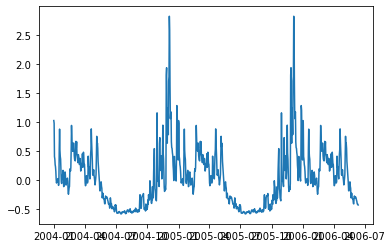

In [209]:
year = '2005'
season_cycle = season_cycle['2005-01-01':'2005-12-31']


# this function reads a date and returns the appropriate value for the seasonal component 
def date_to_seasonal(date):
    month = date.month
    day = date.day
    
    if day == 29 and month == 2:
        day = 28
        
    date = "{}-{}-{}".format(year, month, day)
    return season_cycle[pd.to_datetime(date, dayfirst=False)]

def build_seasonal(dataframe):
    indices = dataframe.index
    seasonal = []
    for i in indices:
        s = date_to_seasonal(i)
        seasonal.append(s)
    
    return pd.Series(seasonal, index=indices)

plt.plot(build_seasonal(train_df))

### We proceed to compute the ACF and PACF of the Hydrometry Residual 

Text(0.5, 1.0, 'PACF Hydrometry Residual')

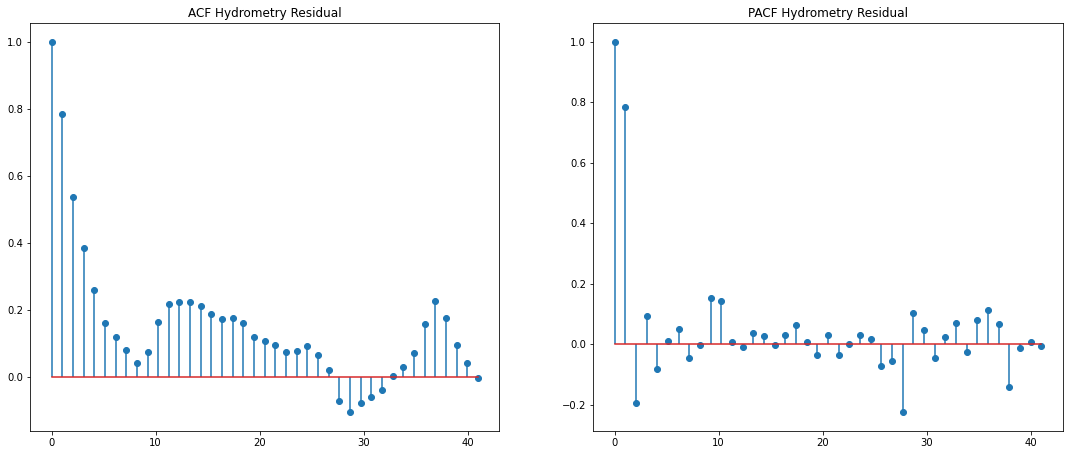

In [178]:
x = np.linspace(0, 41, 41)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

acov = sm.tsa.stattools.acf(decomp.resid, fft=False, nlags=40)
ax[0, 0].stem(x, acov, use_line_collection=True)
ax[0, 0].set_title("ACF Hydrometry Residual")

pacov = sm.tsa.stattools.pacf(decomp.resid, nlags=40)
ax[0, 1].stem(x, pacov, use_line_collection=True)
ax[0, 1].set_title("PACF Hydrometry Residual")

### While the CCF tapers off at lag 7, we have previously shown that rainfall features up to lag 8 exhibit colinearity. We therefore choose to limit the rainfall features to lag 2, as was done previously.

Text(0.5, 1.0, 'Cross-Covariance with second rainfall feature')

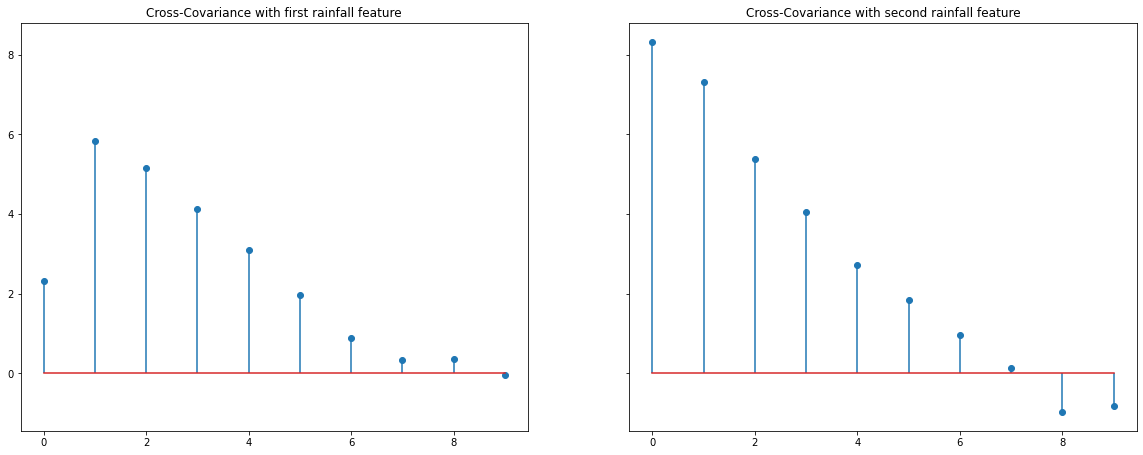

In [179]:
X_rain_1 = np.power(X_rain[:, 0:6], 1).sum(-1)
X_rain_2 = np.power(X_rain[:, 6:], 1).sum(-1)

x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(1, 2, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

ccov = sm.tsa.stattools.ccovf(decomp.resid + decomp.trend, X_rain_1)
ax[0].stem(x, ccov[:10], use_line_collection=True)
ax[0].set_title("Cross-Covariance with first rainfall feature")

ccov = sm.tsa.stattools.ccovf(decomp.resid + decomp.trend, X_rain_2)
ax[1].stem(x, ccov[:10], use_line_collection=True)
ax[1].set_title("Cross-Covariance with second rainfall feature")

### We rewrite the get_feature method to use the residual from the STL decomposition as the target

In [180]:
def concat_previous_values(prev_df, curr_df, max_lag):
    
    columnVals = curr_df.columns.map(lambda x: x.startswith("Rainfall"))
    df_rainfall = curr_df.filter(df.columns[columnVals], axis=1)
    
    df_rainfall = prev_df[-max_lag:].filter(df.columns[columnVals], axis=1)
    df_rainfall = pd.concat([df_rainfall, curr_df.filter(df.columns[columnVals], axis=1)])
    
    return df_rainfall

def get_features_with_residual(features, target, cycle, max_lag, train=True):
    
    columnVals = features.columns.map(lambda x: x.startswith("Rainfall"))
    df_rainfall = features.filter(features.columns[columnVals], axis=1)

    X_rain = df_rainfall.to_numpy()
    
    # split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
    # and the second component is a function of rainfall in region 2: columns 6 to 13 
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=1, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=1, axis=-1) / 100
    
    shift = max_lag if train else 0 
    
    data = {"rainfall_1": rainfall_1[max_lag:],
            "rainfall_2": rainfall_2[max_lag:]}
        
    for i in range(1, max_lag + 1):
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i:-i]
        
    hydrometry = target["Hydrometry_Nave_di_Rosano"]
    
    # subtract seasonal component 
    target = hydrometry - build_seasonal(hydrometry)
    target = target[shift:]
    
    #decomp = seasonal_decompose(hydrometry, period=365, model='additive', extrapolate_trend='freq')
    #target = decomp.resid[max_lag:] + decomp.trend[max_lag:]
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target

In [182]:
exog, target = get_features_with_residual(train_df, train_df, season_cycle, max_lag=2)
model = ARIMA(endog=target, exog=exog, order=(1, 0, 1)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  892
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 190.006
Date:                Mon, 15 Mar 2021   AIC                           -360.013
Time:                        23:37:25   BIC                           -312.078
Sample:                    01-03-2004   HQIC                          -341.694
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4714      0.041     35.875      0.000       1.391       1.552
rainfall_1          -0.0080      0.012     -0.668      0.504      -0.031       0.015
rainfall_2           0.1835      0.012     15.956      0.000       0.161       0.206
rainfall_2_lag_1     0.1066      0.014      7.592      0.000       0.079       0.134
rainfall_1_lag_1     0.0858      0.018      4.703      0.000       0.050       0.122
rainfall_2_lag_2     0.0471      0.013      3.506      0.000       0.021       0.073
rainfall_1_lag_2     0.0297      0.018      1.660      0.097      -0.005       0.065
ar.L1                0.6954      0.027     25.808      0.000       0.643       0.748
ma.L1                0.2628      0.034      7.711      0.000       0.196       0.330
sigma2               0.0382      0.001     52.086      0.000       0.037       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              9357.44
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### Predictions of the hydrometry residual achieve a higher R2 score than those of the hydrometry difference 

2006-06-13 00:00:00 2006-06-12 00:00:00
MSE: 0.0659
MAE: 0.143
R2: 0.747


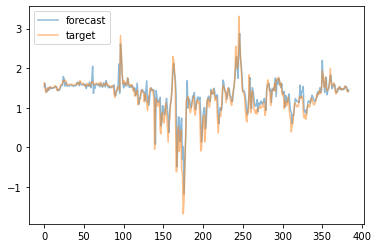

In [183]:
val_rainfall = concat_previous_values(train_df, val_df, max_lag=2)
exog, target = get_features_with_residual(val_rainfall, val_df, season_cycle, max_lag=2, train=False)
pred, gt = get_forecast(exog, target, results, horizon=1)

MSE: 0.169
MAE: 0.246
R2: 0.351


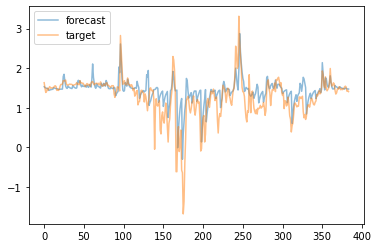

In [185]:
val_rainfall = concat_previous_values(train_df, val_df, max_lag=2)
exog, target = get_features_with_residual(val_rainfall, val_df, season_cycle, max_lag=2, train=False)
pred, gt = get_forecast(exog, target, results, horizon=6)